## Imports

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_groq.chat_models import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver

from pprint import pprint as pp
import os
from dotenv import load_dotenv
load_dotenv()

True

Persistence gives us
1. Short term memory
2. Fault tolerance
3. Human-in-the-loop
4. Time travel

## 1. Simple workflow involving "presistence"

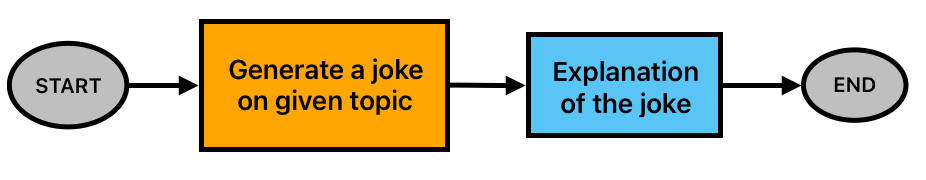

In [2]:
class ChatState(TypedDict):
    topic: str
    joke: str
    explanation: str

LLM = ChatGroq(model=os.getenv("MODEL_NAME", "llama-3.1-8b-instant"), temperature=0.7)

In [3]:
def gen_joke(state: ChatState):
    prompt = f""" You are a funny GenZ comedian. Generate a joke on the following topic: {state['topic']}. RETURN ONLY THE JOKE. DO NOT RETURN ANYTHING ELSE."""
    response = LLM.invoke(prompt).content
    return {"joke": response}

def expl_joke(state: ChatState):
    prompt = f""" You are a helpful assistant. Explain the following joke in simple terms.
        Topic: {state['topic']}
        Joke: {state['joke']}
        RETURN ONLY THE EXPLANATION. DO NOT RETURN ANYTHING ELSE.
    """
    response = LLM.invoke(prompt).content
    return {"explanation": response}

In [4]:
graph = StateGraph(ChatState)
checkpointer = InMemorySaver()

graph.add_node("generate_joke", gen_joke)
graph.add_node("generate_explanation", expl_joke)

graph.add_edge(START, "generate_joke")
graph.add_edge("generate_joke", "generate_explanation")
graph.add_edge("generate_explanation", END)

joke_generator = graph.compile(checkpointer=checkpointer)

In [8]:
topic = "GTA 6"
config1 = {"configurable": {"thread_id": "joke-thread-1"}}
initial_state = {"topic": topic}
response = joke_generator.invoke(initial_state, config=config1)
print("Joke:", response["joke"])
print("Explanation:", response["explanation"])

Joke: "Why did GTA 6 go to therapy? Because it's struggling to balance its characters, and let's be real, it's about to be a whole 'nother level of Grand Theft... Identity Crisis."
Explanation: The joke is about the video game Grand Theft Auto 6 (GTA 6) going to therapy. "Balance its characters" is a play on words, as in the game, characters have personalities and traits, but also, it's a common issue people go to therapy for - struggling to balance their own identities. The punchline "Grand Theft... Identity Crisis" is a pun, combining the game's title "Grand Theft" with the real-life issue of an identity crisis, making it a humorous way to comment on the game's potential storyline or character development.


In [9]:
pp(joke_generator.get_state(config=config1).values)

{'explanation': 'The joke is about the video game Grand Theft Auto 6 (GTA 6) '
                'going to therapy. "Balance its characters" is a play on '
                'words, as in the game, characters have personalities and '
                "traits, but also, it's a common issue people go to therapy "
                'for - struggling to balance their own identities. The '
                'punchline "Grand Theft... Identity Crisis" is a pun, '
                'combining the game\'s title "Grand Theft" with the real-life '
                'issue of an identity crisis, making it a humorous way to '
                "comment on the game's potential storyline or character "
                'development.',
 'joke': '"Why did GTA 6 go to therapy? Because it\'s struggling to balance '
         "its characters, and let's be real, it's about to be a whole 'nother "
         'level of Grand Theft... Identity Crisis."',
 'topic': 'GTA 6'}


In [10]:
pp(list(joke_generator.get_state_history(config=config1))[::-1])

[StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': 'joke-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e571e-24b3-6ba2-bfff-06c4d3412d7d'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-12-30T11:22:53.913173+00:00', parent_config=None, tasks=(PregelTask(id='48b21d9d-7af0-71f9-a953-f99a93b5ed9d', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'topic': 'tik tok cats'}),), interrupts=()),
 StateSnapshot(values={'topic': 'tik tok cats'}, next=('generate_joke',), config={'configurable': {'thread_id': 'joke-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e571e-24b7-61f8-8000-52663c2aef5a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-30T11:22:53.914558+00:00', parent_config={'configurable': {'thread_id': 'joke-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e571e-24b3-6ba2-bfff-06c4d3412d7d'}}, tasks=(PregelTask(id='d202a40f-c2

Sequentially we have "saved" the states.  
And if one runs the workflow again, we can see even those states getting saved!

Also notice that after invocating the workflow with new topic, the previous states were the same, and then began sequentially updating.


In [11]:
topic = "tik tok"
config2 = {"configurable": {"thread_id": "joke-thread-2"}}
initial_state = {"topic": topic}
response = joke_generator.invoke(initial_state, config=config2)
print("Joke:", response["joke"])
print("Explanation:", response["explanation"])

Joke: "Hey, have you guys ever tried to make a TikTok video, but it's just your cat staring at the camera for 10 seconds? That's not content creation, that's just hostage negotiations."
Explanation: This joke is saying that a TikTok video of a cat staring at the camera for 10 seconds might look like a normal short video, but it's actually like a situation where the cat has taken control and is essentially holding things hostage, refusing to do or show anything else, until the person making the video gives in to their demands (in this case, not trying to get the cat to do anything else).


In [12]:
initial_state = {"topic": "lol"}
response = joke_generator.invoke(initial_state, config=config2)

In [13]:
pp(joke_generator.get_state(config=config2).values)

{'explanation': 'The joke is a play on words. "LOL" is a common way to express '
                "laughter online, but in this joke, it's personified as going "
                'to therapy because it\'s feeling "low-key" (which has a '
                'double meaning of feeling a bit down, but also sounds similar '
                'to "low key", meaning quietly or subtly). The punchline is '
                'funny because "LOL" wants to "express itself", which is '
                'ironic since "LOL" is a way of expressing laughter through an '
                'abbreviation.',
 'joke': 'Why did the "LOL" button go to therapy? Because it was feeling a '
         'little "low-key" and wanted to express itself.',
 'topic': 'lol'}


In [14]:
pp(list(joke_generator.get_state_history(config=config2))[::-1])

[StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': 'joke-thread-2', 'checkpoint_ns': '', 'checkpoint_id': '1f0e5722-4e46-6538-bfff-3d2b09d5f34d'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-12-30T11:24:45.646563+00:00', parent_config=None, tasks=(PregelTask(id='6ca2847c-a8e4-4adb-c1b8-149187f625c3', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'topic': 'tik tok'}),), interrupts=()),
 StateSnapshot(values={'topic': 'tik tok'}, next=('generate_joke',), config={'configurable': {'thread_id': 'joke-thread-2', 'checkpoint_ns': '', 'checkpoint_id': '1f0e5722-4e49-61ca-8000-efa82daee041'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-30T11:24:45.647700+00:00', parent_config={'configurable': {'thread_id': 'joke-thread-2', 'checkpoint_ns': '', 'checkpoint_id': '1f0e5722-4e46-6538-bfff-3d2b09d5f34d'}}, tasks=(PregelTask(id='b7332696-d647-34fb-27

In [15]:
topic = "anime"
config3 = {"configurable": {"thread_id": "joke-thread-3"}}
initial_state = {"topic": topic}
response = joke_generator.invoke(initial_state, config=config3)
print("Joke:", response["joke"])
print("Explanation:", response["explanation"])

Joke: "Why did the anime character bring a ladder to the fight? Because he wanted to take his rage to the next level, but also because his creator was low-key trying to reach the next plot twist."
Explanation: The joke is a play on words and references to anime. In anime, characters often have intense emotional transformations or "power ups" that take their abilities to the next level. The ladder in the joke is a literal item that allows the character to elevate their rage. The punchline also references the creator of the anime series, implying that they are using the character's use of a ladder to advance the plot in an unexpected way, or "reach the next plot twist."


In [16]:
pp(list(joke_generator.get_state_history(config=config3))[::-1])

[StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': 'joke-thread-3', 'checkpoint_ns': '', 'checkpoint_id': '1f0e572d-7b8c-6ca8-bfff-486c7e8402e0'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-12-30T11:29:45.673021+00:00', parent_config=None, tasks=(PregelTask(id='de4596ef-b51c-7d96-370e-0bc54116b648', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'topic': 'anime'}),), interrupts=()),
 StateSnapshot(values={'topic': 'anime'}, next=('generate_joke',), config={'configurable': {'thread_id': 'joke-thread-3', 'checkpoint_ns': '', 'checkpoint_id': '1f0e572d-7b93-60e4-8000-eb8b1a586a4d'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-30T11:29:45.675540+00:00', parent_config={'configurable': {'thread_id': 'joke-thread-3', 'checkpoint_ns': '', 'checkpoint_id': '1f0e572d-7b8c-6ca8-bfff-486c7e8402e0'}}, tasks=(PregelTask(id='274ab3b9-08fe-5825-0be8-3

## 2. Fault tolerance

In [17]:
import time

class CrashState(TypedDict):
    user_input: str
    step1: str
    step2: str
    step3: str

In [45]:
def do_step1(state: CrashState):
    time.sleep(1)
    print("Step 1 complete")
    return {"step1": "done", "input": state["user_input"]}

def do_step2(state: CrashState):
    print("Step 2 ongoing")
    time.sleep(10)
    return {"step2": "done"}

def do_step3(state: CrashState):
    print("Step 3 complete")
    return {"step3": "done"}

In [46]:
graph = StateGraph(CrashState)
checkpointer = InMemorySaver()

graph.add_node("step1", do_step1)
graph.add_node("step2", do_step2)
graph.add_node("step3", do_step3)

graph.add_edge(START, "step1")
graph.add_edge("step1", "step2")
graph.add_edge("step2", "step3")
graph.add_edge("step3", END)

crash_process = graph.compile(checkpointer=checkpointer)

In [47]:
config = {"configurable": {"thread_id": "crash-thread"}}
initial_state = {"user_input": "Start the process"}


In [48]:
try:
    print("Running workflow...")
    crash_process.invoke(initial_state, config=config)
except KeyboardInterrupt:
    print("Simulated the crash (workflow interrupted by user)")

Running workflow...
Step 1 complete
Step 2 ongoing
Simulated the crash (workflow interrupted by user)


In [49]:
pp(list(crash_process.get_state_history(config=config))[::-1])

[StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': 'crash-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57b5-43a7-681e-bfff-6c45c8f888df'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-12-30T12:30:30.534140+00:00', parent_config=None, tasks=(PregelTask(id='dd67c032-07b7-a825-219f-1979f38a0ec6', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'user_input': 'Start the process'}),), interrupts=()),
 StateSnapshot(values={'user_input': 'Start the process'}, next=('step1',), config={'configurable': {'thread_id': 'crash-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57b5-43a9-6394-8000-b2f045f4169c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-30T12:30:30.534843+00:00', parent_config={'configurable': {'thread_id': 'crash-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57b5-43a7-681e-bfff-6c45c8f888df'}}, tasks=(PregelTask(id='95

In [50]:
crash_process.get_state(config=config).values # step 2 still not done !!

{'user_input': 'Start the process', 'step1': 'done'}

In [51]:
# the resume/re-run logic

crash_process.invoke(None, config=config) # do not pass an initial state to resume
# on the basis of config, it will resume from where it left off

crash_process.get_state(config=config).values

Step 2 ongoing
Step 3 complete


{'user_input': 'Start the process',
 'step1': 'done',
 'step2': 'done',
 'step3': 'done'}

In [ ]:
pp(list(crash_process.get_state_history(config=config))[::-1]) # now full workflow has executed!

[StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': 'crash-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57b5-43a7-681e-bfff-6c45c8f888df'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-12-30T12:30:30.534140+00:00', parent_config=None, tasks=(PregelTask(id='dd67c032-07b7-a825-219f-1979f38a0ec6', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'user_input': 'Start the process'}),), interrupts=()),
 StateSnapshot(values={'user_input': 'Start the process'}, next=('step1',), config={'configurable': {'thread_id': 'crash-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57b5-43a9-6394-8000-b2f045f4169c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-30T12:30:30.534843+00:00', parent_config={'configurable': {'thread_id': 'crash-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57b5-43a7-681e-bfff-6c45c8f888df'}}, tasks=(PregelTask(id='95

## 3. Human-in-the-loop

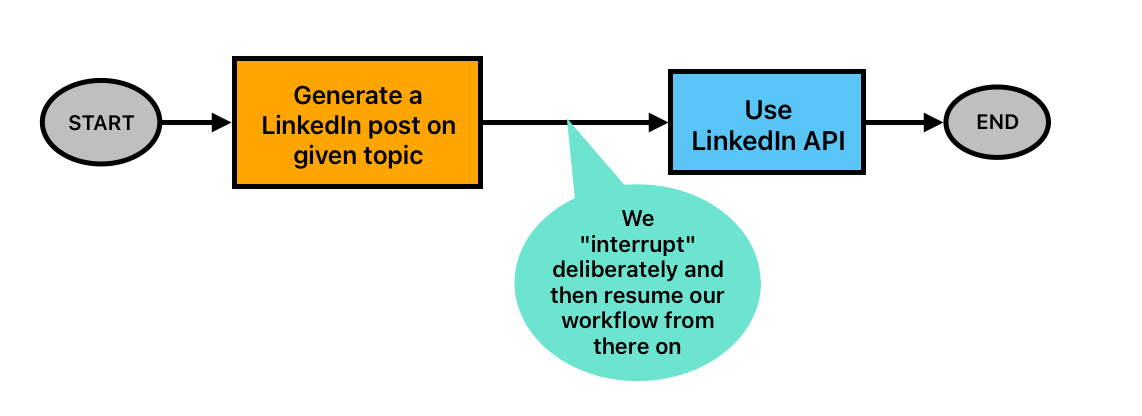

## 4. Time travel

We can replay the execution of our workflow. Like even after entire workflow get executed we can replay from a particular checkpoint.  
Helps with **debugging**!

Say we wish to see how the joke on **GTA 6** was generated.  
So we go to the checkpoint where we just got the `topic`, but `joke` is yet to be generated.  
So we can reach there using that particular `checkpoint_id` (and ofcourse the `thread_id` as well) inside our `StateSnapshot` object.

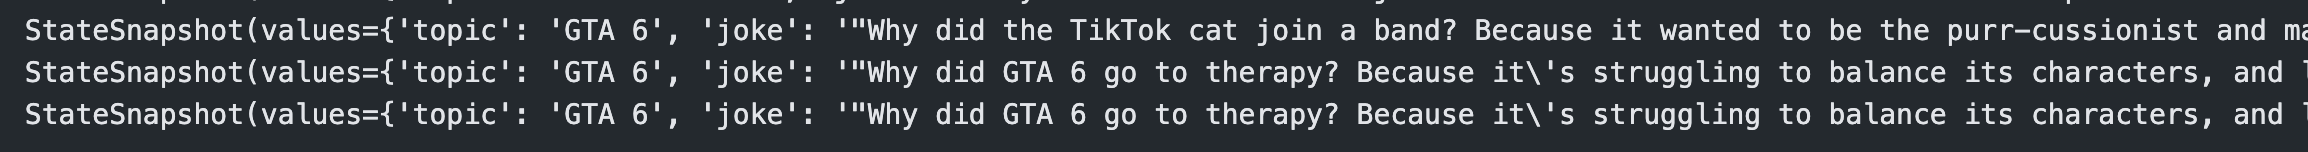

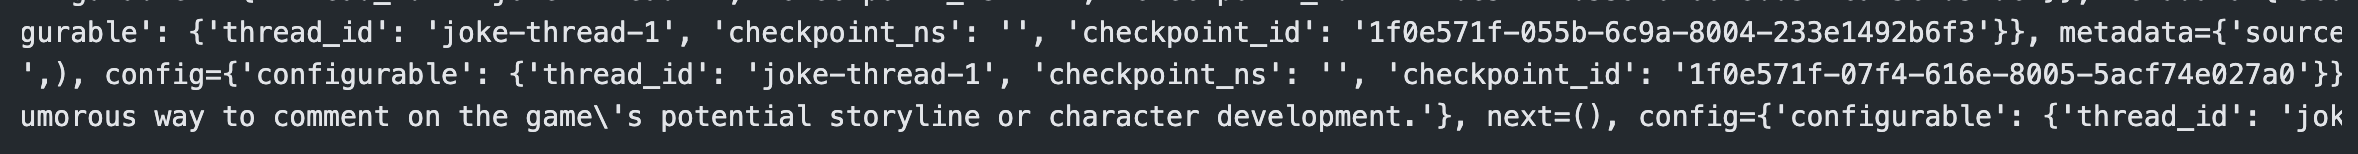

In [53]:
{"configurable" :{'thread_id': 'joke-thread-1', 'checkpoint_id': '1f0e571f-055b-6c9a-8004-233e1492b6f3'}}

{'configurable': {'thread_id': 'joke-thread-1',
  'checkpoint_id': '1f0e571f-055b-6c9a-8004-233e1492b6f3'}}

In [60]:
snap = joke_generator.get_state({"configurable" :{'thread_id': 'joke-thread-1', 'checkpoint_id': '1f0e571f-055b-6c9a-8004-233e1492b6f3'}})

In [61]:
snap.next

('generate_joke',)

In [62]:
snap.values # joke on GTA 6 was NOT generated yet (it was previous invocation's joke)

{'topic': 'GTA 6',
 'joke': '"Why did the TikTok cat join a band? Because it wanted to be the purr-cussionist and make some mew-sic go viral, but honestly, it just ended up being a cat-astrophe."',
 'explanation': "The joke is about a cat on TikTok (a social media platform) that wants to be a musician, specifically a percussionist (a person who plays drums). The cat hopes its music will go viral (become very popular). However, the joke says that instead of being successful, it ends up being a disaster (cat-astrophe) because the cat, being a cat, can't really play music well, making it a humorous and relatable situation."}

In [63]:
joke_generator.invoke(None, {"configurable" :{'thread_id': 'joke-thread-1', 'checkpoint_id': '1f0e571f-055b-6c9a-8004-233e1492b6f3'}})

{'topic': 'GTA 6',
 'joke': '"Guys, I heard GTA 6 is coming out, and I\'m low-key excited, but high-key worried, \'cause I just spent $500 on GTA V and now I\'m gonna have to spend another $100 on GTA 6, and then my mom\'s gonna ask me why my wallet looks like a Grand Theft Auto mission."',
 'explanation': "The joke is saying that the person is secretly excited about GTA 6, but also worried about spending money on it, especially because they just spent a lot of money on GTA 5. The punchline is a play on words, comparing the state of their wallet to a mission in a Grand Theft Auto game, implying it's a chaotic and messy situation, similar to the missions in the game."}

The joke changed as well.  
And we now have the new states added up as well due to our "time travel".  
Kinda like a *fork* of the branch where we re-run from the node `generate_joke` (our next node).

In [64]:
list(joke_generator.get_state_history({"configurable" :{'thread_id': 'joke-thread-1'}}))

[StateSnapshot(values={'topic': 'GTA 6', 'joke': '"Guys, I heard GTA 6 is coming out, and I\'m low-key excited, but high-key worried, \'cause I just spent $500 on GTA V and now I\'m gonna have to spend another $100 on GTA 6, and then my mom\'s gonna ask me why my wallet looks like a Grand Theft Auto mission."', 'explanation': "The joke is saying that the person is secretly excited about GTA 6, but also worried about spending money on it, especially because they just spent a lot of money on GTA 5. The punchline is a play on words, comparing the state of their wallet to a mission in a Grand Theft Auto game, implying it's a chaotic and messy situation, similar to the missions in the game."}, next=(), config={'configurable': {'thread_id': 'joke-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57e4-be3b-6de4-8006-f53e51cb13fe'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-12-30T12:51:45.034153+00:00', parent_config={'configurable': {'thread_id': 'joke-threa

### Updating the state value as well using the checkpointers

In [66]:
joke_generator.update_state(config={"configurable" :{'thread_id': 'joke-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e571f-055b-6c9a-8004-233e1492b6f3'}}, values={"topic": "Poor Marvel films post Endgame. :( "})

{'configurable': {'thread_id': 'joke-thread-1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e57f4-cbd1-62c8-8005-351ab8629dd5'}}

We have got the new `config`, and we can use this to invoke our workflow from above particular checkpoint.

In [67]:
joke_generator.invoke(None, config={'configurable': {'thread_id': 'joke-thread-1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e57f4-cbd1-62c8-8005-351ab8629dd5'}})

{'topic': 'Poor Marvel films post Endgame. :( ',
 'joke': '"Why did Doctor Strange bring a ladder to the Multiverse Saga? Because he wanted to level up, but honestly, after Endgame, it\'s like Marvel\'s just been stuck in a time loop, reliving the same plot for years..."',
 'explanation': 'The joke is saying that Doctor Strange brought a ladder to the Multiverse Saga so he could "level up" (improve or upgrade). However, the joke is also making a pun on the idea of being stuck in a time loop. The phrase "level up" has a double meaning here - it\'s a gaming term where a character gains experience and becomes stronger, but it also sounds similar to "live the same plot over and over again," implying that Marvel\'s movies have become repetitive and unoriginal after the events of Endgame.'}

In [69]:
list(joke_generator.get_state_history({"configurable" :{'thread_id': 'joke-thread-1'}}))[:4]

[StateSnapshot(values={'topic': 'Poor Marvel films post Endgame. :( ', 'joke': '"Why did Doctor Strange bring a ladder to the Multiverse Saga? Because he wanted to level up, but honestly, after Endgame, it\'s like Marvel\'s just been stuck in a time loop, reliving the same plot for years..."', 'explanation': 'The joke is saying that Doctor Strange brought a ladder to the Multiverse Saga so he could "level up" (improve or upgrade). However, the joke is also making a pun on the idea of being stuck in a time loop. The phrase "level up" has a double meaning here - it\'s a gaming term where a character gains experience and becomes stronger, but it also sounds similar to "live the same plot over and over again," implying that Marvel\'s movies have become repetitive and unoriginal after the events of Endgame.'}, next=(), config={'configurable': {'thread_id': 'joke-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e57f8-7e89-63e0-8007-1085f05b46f8'}}, metadata={'source': 'loop', 'step': 7, 